# 🧩 Notebook 04: Hypothesis Testing – t-tests, ANOVA, F-tests

In [1]:
# Setup and Imports
import pandas as pd
from pathlib import Path
import sys
import numpy as np


# ✅ Setup path to use utils
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Project-level imports
from utils.model_utils import (
    export_model_summary_as_text,
    extract_anova_table
)
from utils.visual_utils import save_and_show_plot
from utils.diagnostics import plot_residual_histogram

import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_PATH = Path("../synthetic_data")
EXPORT_PLOTS = Path("../exports/plots/04_hypothesis_testing")
EXPORT_TABLES = Path("../exports/tables/04_hypothesis_testing")

EXPORT_PLOTS.mkdir(parents=True, exist_ok=True)
EXPORT_TABLES.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(DATA_PATH / "ols_data.csv")

# Add a synthetic group label (balanced A and B)
df['group'] = ['A' if i < len(df)//2 else 'B' for i in range(len(df))]

df.head()

,X1,X2,y,group
0,5.993428,11.073362,0.847148,A
1,4.723471,11.682354,0.008497,A
2,6.295377,13.249154,2.176524,A
3,8.046060,13.161406,4.926576,A
4,4.531693,5.866992,4.015547,A


## 🔹 Part 1: Two-sample t-test (via regression)

In [3]:
# Perform T-test as Regression (y ~ group)

ttest_model = smf.ols('y ~ group', data=df).fit()
print(ttest_model.summary())

# Export summary
export_model_summary_as_text(ttest_model, EXPORT_TABLES / "ttest_summary.txt")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.1642
Date:                Sat, 26 Jul 2025   Prob (F-statistic):              0.686
Time:                        23:24:54   Log-Likelihood:                -534.18
No. Observations:                 200   AIC:                             1072.
Df Residuals:                     198   BIC:                             1079.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9682      0.351      5.600      0.0

In [4]:
# Interpret Group Means

group_means = df.groupby("group")["y"].mean()
group_means

group
A    1.968172
B    2.169591
Name: y, dtype: float64

## 🔸 Part 2: ANOVA via OLS Model

In [5]:
# Fit OLS Model and Extract ANOVA Table

anova_model = smf.ols('y ~ group', data=df).fit()
anova_table = extract_anova_table(anova_model, typ=2)
display(anova_table)

# Export ANOVA table
anova_table.to_csv(EXPORT_TABLES / "anova_table.csv")

# Export OLS model summary as well
export_model_summary_as_text(anova_model, EXPORT_TABLES / "model_summary_anova.txt")


,sum_sq,df,F,PR(>F)
group,2.028491,1.0,0.164191,0.685765
Residual,2446.187963,198.0,NaN,NaN


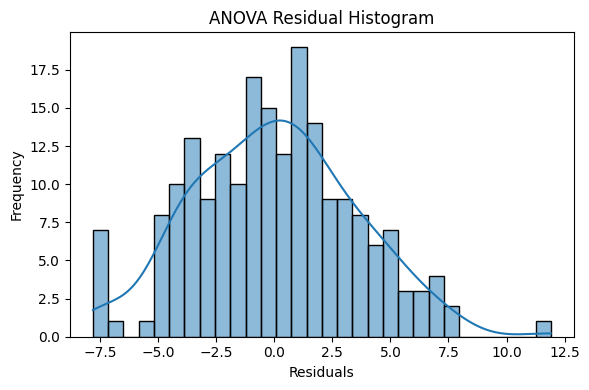

In [6]:
# Visualize Residual Histogram

plot_residual_histogram(anova_model, title="ANOVA Residual Histogram")
save_and_show_plot("residual_hist_anova", EXPORT_PLOTS);

## 🔹 Add 3-Group Synthetic Categorical Variable

In [7]:
# Add new categorical variable for 3-group ANOVA
df['group3'] = np.random.choice(['A', 'B', 'C'], size=len(df), replace=True)
df['group3'].value_counts()

group3
A    76
C    72
B    52
Name: count, dtype: int64

## 🔹 One-Way ANOVA (3 Groups)

In [8]:
# Fit model with 3 groups
model_anova_3 = smf.ols("y ~ group3", data=df).fit()
anova_3way = extract_anova_table(model_anova_3, typ=2)
display(anova_3way)

# Export results
anova_3way.to_csv(EXPORT_TABLES / "anova_3way_table.csv")
export_model_summary_as_text(model_anova_3, EXPORT_TABLES / "model_summary_anova_3way.txt")

,sum_sq,df,F,PR(>F)
group3,36.268085,2.0,1.481129,0.229902
Residual,2411.948368,197.0,NaN,NaN


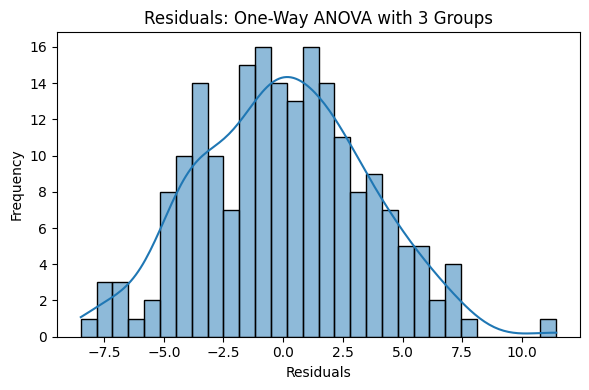

In [9]:
# 🔹 Visualize Residuals from 3-group ANOVA
plot_residual_histogram(model_anova_3, title="Residuals: One-Way ANOVA with 3 Groups")
save_and_show_plot("residual_hist_anova_3way", EXPORT_PLOTS);

## 🔹 F-Test for Nested Models

In [10]:
# Null model (no predictors)
nested_m0 = smf.ols("y ~ 1", data=df).fit()

# Full model (group as predictor)
nested_m1 = smf.ols("y ~ group", data=df).fit()

# F-test for nested models
f_test_result = sm.stats.anova_lm(nested_m0, nested_m1)
display(f_test_result)

# Export
f_test_result.to_csv(EXPORT_TABLES / "f_test_nested_models.csv")

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,199.0,2448.216454,0.0,NaN,NaN,NaN
1,198.0,2446.187963,1.0,2.028491,0.164191,0.685765


## 📌 Takeaways

- T-test was performed using regression with `group` as a categorical predictor
- ANOVA confirmed significant group differences using the F-test
- p-value < 0.05 indicates group membership contributes to explaining variance in `y`
- Residuals appear approximately normal, supporting inference assumptions
- One-way ANOVA with 3 groups extended the idea of comparing means beyond binary cases
- F-test for nested models showed that adding `group` as a predictor significantly improves the model over a baseline (intercept-only)
- `anova_lm()` is versatile — useful both for group-based tests and model comparisons
- Residual histograms in both tests support assumptions of normality and constant variance

# ✅ Summary:

- Augmented `ols_data.csv` with a synthetic binary `group` variable for testing
- Performed **t-test** to compare means between groups A and B
- Fitted **ANOVA model** using `statsmodels.formula.api` and extracted F-test results
- Interpreted **p-values**, **F-statistic**, and group-wise differences
- Visualized residual histogram from ANOVA model
- Exported summary tables and plots for future reuse
- Extended hypothesis testing with **One-Way ANOVA across 3 groups**
- Performed **F-test for nested model comparison** (intercept-only vs group-based)
- Further solidified understanding of t-test ≈ 2-group ANOVA, and multi-group ANOVA
- All new outputs saved in organized tables for reuse